Let $s$ be a sequence of i.i.d. unbiased coin flips (heads are 1, tails are 0), represented as series $I(t)$ of input pulses with pulse width 1 when $s_m = 1$. Given a 1-D linear system with timescale $\tau$ we want to figure out response distribution $P(r)$ given response resolution $1/\Delta r$, where 

$$r = \int_0^\infty \frac{1}{\tau}\exp(-t/\tau) I(-t) dt$$

and where $t=0$ aligns with the pulse boundary (i.e. so $t=0$ is never in the middle of a pulse).

We want to calculate the probability that $r$ lands in the nth bin of size $\Delta r$ where the number of bins is $N = 1/\Delta r$. 

Note $0 \leq r \leq 1$, $n \in \{0, 1, ..., N-1\}$.

We have $$P(r \textrm{ in nth bin}) = P(n\Delta r \leq r < (n+1)\Delta r) = 1 - P(r < n\Delta r) - P(r \geq (n+1)\Delta r)$$

If the mth symbol, whose pulse spans time $m$ and $m+1$, is 1, it contributes

$$r_m = \int_m^{m+1} \frac{1}{\tau} \exp(-t/\tau) dt = -[\exp(-(m+1)/\tau) - \exp(-m/\tau)] = \exp(-m/\tau)[1 - \exp(-1/\tau)]$$

and 0 if the symbol is 0.

Thus, $$r = \sum_{m=0}^\infty s_mr_m = [1 - \exp(-1/\tau)]\sum_{m=0}^\infty s_m\exp(-m/\tau) = \gamma_\tau \sum_{m=0}^\infty s_m\exp(-m/\tau)$$

So $$P(r < n\Delta r) = P\left(\sum_{m=0}^\infty s_m\exp(-m/\tau) < n\frac{\Delta r}{\gamma_\tau}\right)$$ 

and 

$$P(r \geq (n+1) \Delta r) = P\left(\sum_{m=0}^\infty s_m\exp(-m/\tau) \geq (n+1)\frac{\Delta r}{\gamma_\tau} \right)$$ 

We thus need to figure out the cumulative distribution and survival functions of an exponentially weighted sum of i.i.d. unbiased Bernoulli variables. Note the bounds $0 \leq \sum_{m=0}^\infty s_m\exp(-m/\tau) \leq 1/\gamma_\tau$.

Since all sequences $s$ have equal probability we can approach this by counting what fraction of sequences end up below/above a specific value. Although there are infinite sequences $s$ they are countable, and we can sort them 

When $0 < \tau < \ln 2$ distr is over binned parameterized version of cantor set. Calc cumul distr using symmetries. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size

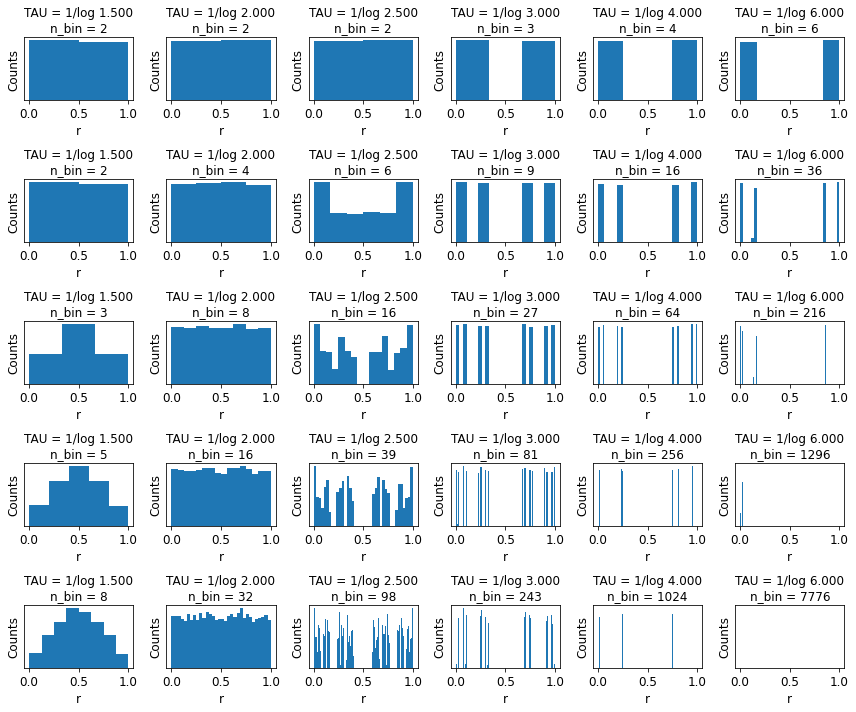

In [2]:
taus = [1/np.log(1.5), 1/np.log(2), 1/np.log(2.5), 1/np.log(3), 1/np.log(4), 1/np.log(6)]
n_rsln = 5
n_s = int(1e4)

fig, axs = plt.subplots(n_rsln, len(taus), figsize=(len(taus)*2, n_rsln*2), tight_layout=True, squeeze=False)

for ctau, tau in enumerate(taus):
    gam = 1 - np.exp(-1/tau)

    l = int(round(10*tau))
    h = gam*np.exp(-np.arange(l)/tau)

    r = np.nan*np.zeros(n_s)

    for ctr in range(n_s):
        r[ctr] = h@np.random.binomial(1, .5, l)
    
    for crsln in range(n_rsln):
        n_bin = int(np.round(np.exp(1/tau)**(crsln+1)))
        bins = np.linspace(0, 1, n_bin+1)
        
        ax = axs[crsln, ctau]
        ax.hist(r, bins=bins)
        ax.set_title(f'TAU = 1/log {np.exp(1/tau):.3f}\nn_bin = {n_bin}')

for ax in axs.flatten():
    ax.set_xlim(-.05, 1.05)
    ax.set_yticks([])
    ax.set_xlabel('r')
    ax.set_ylabel('Counts')
    
set_font_size(axs, 12)

We want to compute this distribution over a range of taus and at a couple resolutions.

A useful variable to introduce is $a = \exp(-1/\tau)$, which is the scale factor governing how quickly each next pulse's contribution to $r$ decays. E.g. when $\tau = 1/\log 2$, we have that $a = 1/2$.

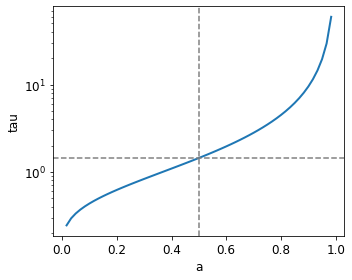

In [3]:
# scale factor (how much each pulse's contribution decays)
a = np.linspace(1/60, 59/60, 59)
tau = 1/np.log(1/a)

fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.semilogy(a, tau, lw=2)
ax.axhline(1/np.log(2), ls='--', color='gray')
ax.axvline(.5, color='gray', ls='--')
ax.set_xlabel('a')
ax.set_ylabel('tau')

set_font_size(ax, 12)

In [4]:
n_s = int(round(2e6))
l = int(round(10*np.max(tau)))

samples = np.random.binomial(1, .5, (l, n_s))

rs = []
for tau_ in tau:
    gam = 1 - np.exp(-1/tau_)
    h = gam*np.exp(-np.arange(l)/tau_)
    rs.append(np.concatenate([h @ samples, 1-h@samples]))
    
rs = np.array(rs)

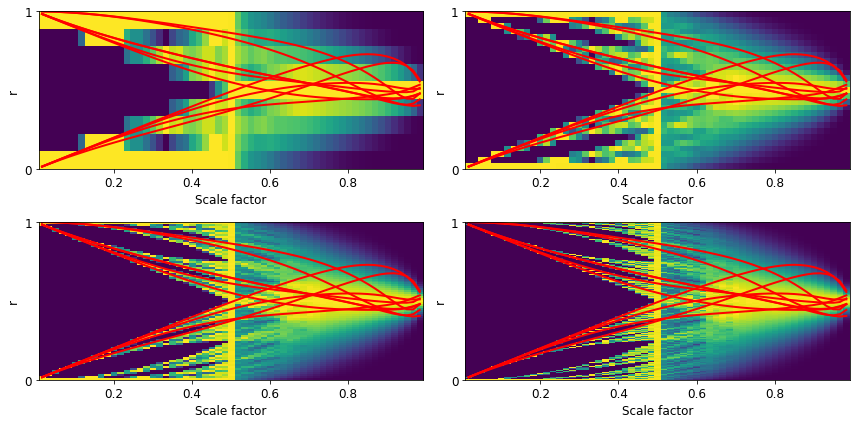

In [10]:
from scipy import stats

n_bins = 3**np.arange(2, 6)
n_xpl = 10
fig, axs = plt.subplots(2, 2, figsize=(12, 6), tight_layout=True)
axs = axs.flatten()

ents = np.nan * np.zeros((len(n_bins), len(tau)))

for cn_bin, (n_bin, ax) in enumerate(zip(n_bins, axs)):
    bins = np.linspace(0, 1, n_bin+1)
    
    cts_normed_all = []
    
    for ctau, r in enumerate(rs):
        cts = np.histogram(r, bins=bins)[0]
        cts_normed = cts/cts.max()
        cts_normed_all.append(cts_normed)
        
        ents[cn_bin, ctau] = stats.entropy(cts/cts.sum(), base=2)
        
    cts_normed_all = np.array(cts_normed_all)
    
    ax.matshow(cts_normed_all.T, interpolation='nearest', extent=[1/120, 119/120, 0, 1], zorder=0)
    
    # overlay samples from full random process
    for cxpl in range(n_xpl):
        ax.plot(a, rs[:, cxpl], lw=2, c='r')
    
    ax.xaxis.tick_bottom()
    ax.set_aspect('auto')
    ax.set_xlabel('Scale factor')
    ax.set_ylabel('r')
    
set_font_size(axs, 12)

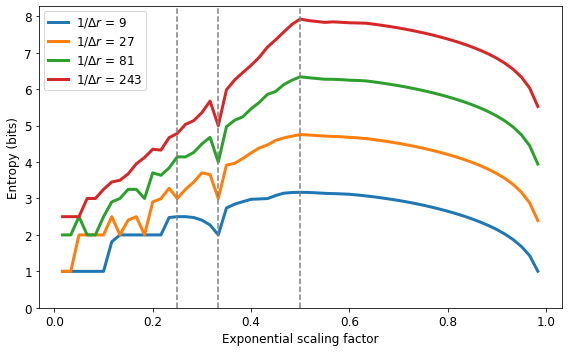

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), tight_layout=True)
ax.plot(a, ents.T, lw=3)
ax.set_ylim(bottom=0)
ax.axvline(1/2, color='gray', ls='--')
ax.axvline(1/3, color='gray', ls='--')
ax.axvline(1/4, color='gray', ls='--')
ax.set_xlabel('Exponential scaling factor')
ax.set_ylabel('Entropy (bits)')
ax.legend([f'1/$\Delta r$ = {n_bin}' for n_bin in n_bins])
set_font_size(ax, 12)

# Small $\tau$ limit

By inspection in the $\tau \rightarrow 0$ limit we have that 

$$\lim_{\tau \rightarrow 0} P(r) = \frac{\delta(r) + \delta(r-1)}{2}$$

i.e. two delta functions at 0 and 1.

# Large $\tau$ limit

By CLT arguments we expect

$$r = \frac{1}{\tau} \int_0^\infty \exp(-t/\tau) I(-t) dt$$

to be Gaussian with mean .5 when $\tau \rightarrow \infty$.

In this limit $r$ will be an exponentially weighted sum of i.i.d. Gaussian RVs, which is itself Gaussian.

We can break up the domain $t \in [0, \infty)$ into chunks of length $T$, where $\tau \gg T \gg 1$. Then 

$$r = \frac{1}{\tau}\left[ \int_0^T \exp(-t/\tau)I(-t)dt +  \int_T^{2T} \exp(-t/\tau)I(-t)dt \int_{2T}^{3T} \exp(-t/\tau)I(-t)dt + \cdots \right]$$

$$\approx \frac{1}{\tau}\left[ \exp\left(-\frac{T}{2\tau}\right) X_0 + \exp\left(-\frac{3T}{2\tau}\right) X_1 + \exp\left(-\frac{5T}{2\tau}\right) X_2 + \cdots \right]$$

where $X_m$ are i.i.d. binomial random variables with mean $T/2$ and variance $T/4$.

Thus each term has variance 

$$\textrm{Var}\left[\frac{1}{\tau}\exp\left(-\frac{(2m+1)T}{2\tau}\right)X_m\right] = \frac{1}{\tau^2}\exp\left(-\frac{(2m+1)T}{\tau}\right)\frac{T}{4} = \frac{T}{4\tau^2}\exp\left(-\frac{(2m+1)T}{\tau}\right) = \frac{T}{4\tau^2}\exp(-T/\tau)\exp\left(-\frac{2mT}{\tau}\right)$$

So the sum has variance 

$$\textrm{Var}[r] = \frac{T}{4\tau^2} \exp(-T/\tau) \sum_{m=0}^\infty \exp(-2T/\tau)^{m}$$

which reduces to 

$$\frac{T}{4\tau^2} \sum_{m=0}^\infty \exp(-2T/\tau)^{m}$$

in the limit of $T/\tau \rightarrow 0, \exp(-T/\tau) \rightarrow 1$.

Finally, since for $a < 1$ we have $\sum_{m=0}^\infty a^m = 1/(1-a)$, we get

$$\lim_{\tau \rightarrow \infty} \textrm{Var}[r] = \frac{T}{4\tau^2}\frac{1}{1 - \exp(-2T/\tau)} = \frac{T}{4\tau^2}\frac{1}{1 - (1 - 2T/\tau)} = \frac{T}{4\tau^2}\frac{\tau}{2T} = \frac{1}{8\tau}$$

So for large $\tau$ we get that $r$ is distributed as a Gaussian with mean .5 and std $1/\sqrt{8\tau}$.

# Recursive distribution approximation

Instead of understanding the distribution of $r$ by sampling then binning, we can also recursively construct it with a precise sequence of steps that converges to the true distribution.

We have $$r = \left[1 - \exp(-1/\tau)\right]\left[s_0 + s_1\exp(-1/\tau) + s_2\exp(-1/\tau)^2 + \cdots\right] = \gamma_\tau\left[s_0 + s_1\exp(-1/\tau) + s_2\exp(-1/\tau)^2 + \cdots\right]$$


$$= y_0 + y_1 + y_2 + \cdots \quad \quad y_m = \gamma_\tau \exp(-1/\tau)^m s_m$$

where each $P(y_m)$ is a pair of equally weighted delta functions at 0 and $\gamma_\tau \exp(-1/\tau)^m$: 

$$P(y_m) = .5\left[\delta(y_m) + \delta(y_m - \gamma_\tau \exp(-1/\tau)^m)\right]$$

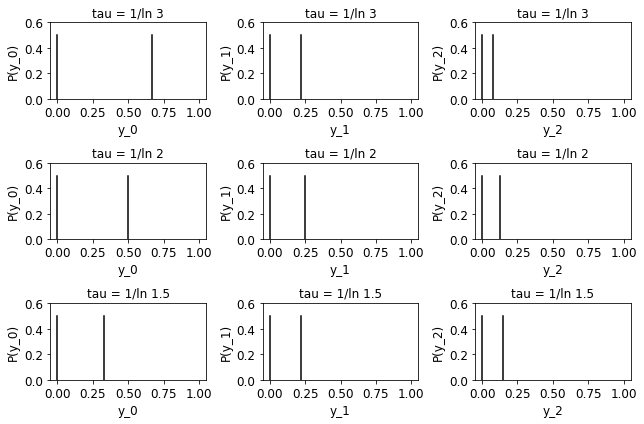

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size

fig, axs = plt.subplots(3, 3, figsize=(9, 6), tight_layout=True)
taus = [
    ('1/ln 3', 1/np.log(3)),
    ('1/ln 2', 1/np.log(2)),
    ('1/ln 1.5', 1/np.log(1.5)),
]

for (ktau, tau), ax_row in zip(taus, axs):
    gam = 1 - np.exp(-1/tau)
    
    for m, ax in enumerate(ax_row):
        ax.plot(2*[0], [0, .5], c='k')
        ax.plot(2*[gam*np.exp(-1/tau)**m], [0, .5], c='k')
        
        ax.set_xlabel(f'y_{m}')
        ax.set_ylabel(f'P(y_{m})')
        ax.set_title(f'tau = {ktau}')
        
for ax in axs.flat:
    ax.set_xlim(-.05, 1.05)
    ax.set_ylim(0, .6)
    set_font_size(ax, 12)

Since $r$ is the sum of independent variables we get that 

$$P(r) = P(y_0) \ast P(y_1) \ast P(y_2) \cdots$$

A first note is that $P(r)$ is uniform between 0 and 1 when $$\gamma_\tau \exp(-1/\tau)^0 = [1-\exp(-1/\tau)] = 1/2 \quad \quad \textrm{i.e.} \quad \quad \tau = 1/\ln 2$$

This is because when we recursively construct $P(r)$ through convolution we see that the possible $r$ we can achieve remain evenly spaced:

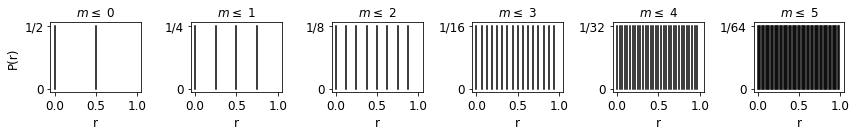

In [23]:
fig, axs = plt.subplots(1, 6, figsize=(12, 2), tight_layout=True)
tau = 1/np.log(2)
gam = 1 - np.exp(-1/tau)

r = np.array([0.])

for m, ax in enumerate(axs.flat):
    r = np.array(list(zip(r, r + gam*np.exp(-m/tau)))).flatten()
    for r_ in r:
        ax.plot([r_, r_], [0, 1/2**(m+1)], c='k')
        
    ax.set_xlim(-.05, 1.05)
    ax.set_yticks([0, 1/2**(m+1)])
    ax.set_yticklabels([0, f'1/{2**(m+1)}'])
    ax.set_xlabel('r')
    if m == 0:
        ax.set_ylabel('P(r)')
    ax.set_title(f'$m \leq$ {m}')
    
set_font_size(axs, 12)

We can perform these convolutions up to $m$ for a few $\tau$:

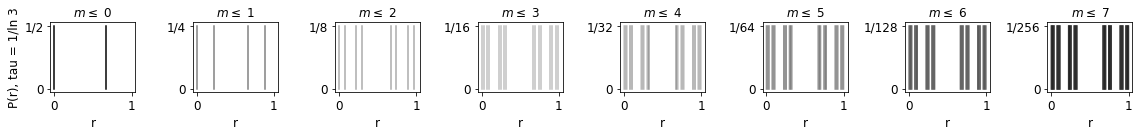

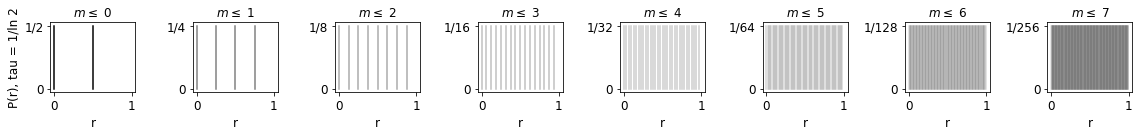

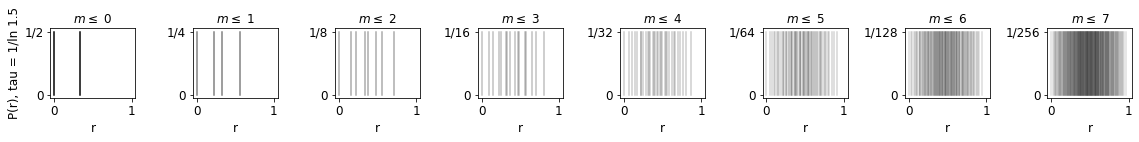

In [41]:
for (ktau, tau) in taus:
    
    fig, axs = plt.subplots(1, 8, figsize=(16, 2), tight_layout=True)
    gam = 1 - np.exp(-1/tau)

    r = np.array([0.])

    for m, ax in enumerate(axs.flat):
        r = np.array(list(zip(r, r + gam*np.exp(-m/tau)))).flatten()
        for r_ in r:
            ax.plot([r_, r_], [0, 1/2**(m+1)], c='k', alpha=1/(m+1))

        ax.set_xlim(-.05, 1.05)
        ax.set_yticks([0, 1/2**(m+1)])
        ax.set_yticklabels([0, f'1/{2**(m+1)}'])
        ax.set_xlabel('r')
        if m == 0:
            ax.set_ylabel(f'P(r), tau = {ktau}')
        ax.set_title(f'$m \leq$ {m}')

    set_font_size(axs, 12)